In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from codecarbon import track_emissions

In [2]:
# Configurações iniciais
TASK = "Infection"  # "Infection" ou "Ischaemia"
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
MODEL_NAME = "efficientnet"  # "efficientnet" ou "resnet50"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Pré-processamento de Imagens
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
root_dir = "../data/infection"


# 2. Dataset Customizado
class DFUDataset(Dataset):
    def __init__(self, root_dir, task=TASK, transform=None):
        self.root_dir = root_dir
        self.task = task

        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.identifiers = []  # Novo campo para identificadores únicos

        # Validate that root_dir is a valid path
        if not isinstance(root_dir, str):
            raise TypeError(f"Expected root_dir to be a string, but got {type(root_dir).__name__}")

        print("TASK: " + TASK)

        positive_dir = os.path.join(root_dir, "Aug-Positive")
        negative_dir = os.path.join(root_dir, "Aug-Negative")


        # Carregar imagens positivas
        for img_name in os.listdir(positive_dir):
            self.image_paths.append(os.path.join(positive_dir, img_name))
            self.labels.append(1)
            # Extrair identificador único (ex: "imagem" de "imagem_1X_M.jpg")
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

        # Carregar imagens negativas
        for img_name in os.listdir(negative_dir):
            self.image_paths.append(os.path.join(negative_dir, img_name))
            self.labels.append(0)
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# 3. Modelo com Regularização
def create_model():
    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1  # Ou ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
    elif MODEL_NAME == "efficientnet":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Ou EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 1)
        )
    return model.to(DEVICE)

In [6]:
# 6. Cálculo de Métricas
def calculate_metrics(true, preds):
    preds_class = (preds > 0.5).astype(int)
    return {
        'auc': roc_auc_score(true, preds),
        'pr_auc': average_precision_score(true, preds),
        'f1': f1_score(true, preds_class),
        'accuracy': accuracy_score(true, preds_class),
        'precision': precision_score(true, preds_class),
        'recall': recall_score(true, preds_class),
        'confusion_matrix': confusion_matrix(true, preds_class)
    }

In [7]:
# 5. Função de Avaliação
@track_emissions(output_dir="../reports/emissions", output_file="infection_efficientnet.csv") 
def evaluate_model(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return np.mean(losses), metrics

In [8]:
# 4. Função de Treinamento com Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, fold):
    best_loss = float('inf')
    patience_counter = 0
    patience = 3

    history = {
        'train_loss': [],
        'val_loss': [],
        'auc': [],
        'f1': []
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validação
        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)
        epoch_loss = running_loss / len(train_loader.dataset)

        # Registrar métricas
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['auc'].append(val_metrics['auc'])
        history['f1'].append(val_metrics['f1'])

        print(f'Fold {fold}, Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Val AUC: {val_metrics["auc"]:.4f}, F1: {val_metrics["f1"]:.4f}')

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    import os
    output_dir = "../models/infection"
    os.makedirs(output_dir, exist_ok=True)
    # Salva o modelo final do fold
    last_path = os.path.join(output_dir, f"last_model_fold{fold}.pth")
    torch.save(model.state_dict(), last_path)

    return history

In [9]:
# 7. Grad-CAM
def generate_grad_cam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_tensor.permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)
    return visualization

In [10]:
def plot_training_histories(histories):
    plt.figure(figsize=(15, 10))

    # Cores para diferentes folds
    colors = ['b', 'g', 'r', 'c', 'm']

    # Plot Loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['train_loss'])+1)
        plt.plot(epochs, history['train_loss'], linestyle='--', color=colors[i], label=f'Fold {i+1} Train')
        plt.plot(epochs, history['val_loss'], linestyle='-', color=colors[i], label=f'Fold {i+1} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot AUC
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['auc'])+1)
        plt.plot(epochs, history['auc'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot F1-Score
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['f1'])+1)
        plt.plot(epochs, history['f1'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig('training_histories.png')
    plt.show()

In [11]:
# 8. Validação Cruzada
@track_emissions(output_dir="../reports/emissions", output_file="infection_efficientnet_cv.csv") 
def cross_validation():

    dataset = DFUDataset("../data/infection", transform=transform)
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  # Alterado para StratifiedGroupKFold

    all_metrics = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(
        X=np.zeros(len(dataset.labels)),  # Dummy data
        y=dataset.labels,
        groups=dataset.identifiers  # Grupos dos identificadores
    )):
        print(f'\nFold {fold+1}/5')

        # Split adicional: 80% treino, 20% teste interno
        train_idx, test_idx = train_test_split(
            train_idx,
            test_size=0.2,
            stratify=np.array(dataset.labels)[train_idx],
            random_state=42
        )

        # Split datasets
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_subsampler)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Inicialização
        model = create_model()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # L2 regularization

        history = train_model(model, train_loader, val_loader, criterion, optimizer, fold+1)
        fold_histories.append(history)

        plot_training_histories(fold_histories)

        # Avaliação no conjunto de teste interno
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, test_metrics = evaluate_model(model, test_loader, criterion)

        # Carregar melhor modelo e avaliar
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, metrics = evaluate_model(model, val_loader, criterion)

         # Adicione as métricas de teste
        all_metrics.append({
            'fold': fold+1,
            'val_metrics': metrics,
            'test_metrics': test_metrics
        })

    pd.DataFrame(fold_histories).to_csv('../reports/metrics/training_history_infection_efficientnet.csv', index=False)


    # Processar all_metrics para formato tabular
    metrics_rows = []
    for m in all_metrics:
        row = {
            'fold': m['fold'],
            **{f'val_{k}': v for k, v in m['val_metrics'].items()},
            **{f'test_{k}': v for k, v in m['test_metrics'].items()}
        }
        metrics_rows.append(row)

    pd.DataFrame(metrics_rows).to_csv('../reports/metrics/fold_metrics_infection_efficientnet.csv', index=False)

    # Relatório Final
    print("\nResultados da Validação Cruzada:")

    # Para métricas de validação
    print("\n--- Métricas de Validação ---")
    for key in all_metrics[0]['val_metrics']:
        if key != 'confusion_matrix':
            mean_val = np.mean([m['val_metrics'][key] for m in all_metrics])
            std_val = np.std([m['val_metrics'][key] for m in all_metrics])
            print(f'Val_{key.upper()}: {mean_val:.4f} ± {std_val:.4f}')

    # Para métricas de teste interno
    print("\n--- Métricas de Teste Interno ---")
    for key in all_metrics[0]['test_metrics']:
        if key != 'confusion_matrix':
            mean_test = np.mean([m['test_metrics'][key] for m in all_metrics])
            std_test = np.std([m['test_metrics'][key] for m in all_metrics])
            print(f'Test_{key.upper()}: {mean_test:.4f} ± {std_test:.4f}')

    return fold_histories, all_metrics

[codecarbon WARNING @ 23:23:41] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:23:41] [setup] RAM Tracking...
[codecarbon INFO @ 23:23:41] [setup] CPU Tracking...
[codecarbon WARNING @ 23:23:43] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 23:23:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 23:23:43] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 23:23:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:23:43] [setup] GPU Tracking...
[codecarbon INFO @ 23:23:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:23:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c

TASK: Infection

Fold 1/5


[codecarbon INFO @ 23:24:01] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:24:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:24:01] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 23:24:01] Energy consumed for all GPUs : 0.000050 kWh. Total GPU Power : 12.004698890559208 W
[codecarbon INFO @ 23:24:01] 0.000386 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:24:16] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:24:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:24:16] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 23:24:16] Energy consumed for all GPUs : 0.000100 kWh. Total GPU Power : 12.045380439752801 W
[codecarbon INFO @ 23:24:16] 0.000772 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 1/100
Train Loss: 0.4353 | Val Loss: 0.6559
Val AUC: 0.7033, F1: 0.6613


[codecarbon INFO @ 23:26:46] Energy consumed for RAM : 0.001900 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:26:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:26:46] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 23:26:46] Energy consumed for all GPUs : 0.000598 kWh. Total GPU Power : 11.83573128915941 W
[codecarbon INFO @ 23:26:46] 0.004623 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:27:01] Energy consumed for RAM : 0.002058 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:27:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:27:01] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 23:27:01] Energy consumed for all GPUs : 0.000648 kWh. Total GPU Power : 11.822799896008837 W
[codecarbon INFO @ 23:27:01] 0.005008 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:2

Fold 1, Epoch 2/100
Train Loss: 0.4128 | Val Loss: 0.6204
Val AUC: 0.7647, F1: 0.7036


[codecarbon INFO @ 23:30:01] Energy consumed for RAM : 0.003957 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:30:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:30:01] Energy consumed for All CPU : 0.004427 kWh
[codecarbon INFO @ 23:30:01] Energy consumed for all GPUs : 0.001245 kWh. Total GPU Power : 12.090070734123788 W
[codecarbon INFO @ 23:30:01] 0.009630 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:30:16] Energy consumed for RAM : 0.004116 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:30:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:30:16] Energy consumed for All CPU : 0.004604 kWh
[codecarbon INFO @ 23:30:16] Energy consumed for all GPUs : 0.001295 kWh. Total GPU Power : 12.00658199141923 W
[codecarbon INFO @ 23:30:16] 0.010015 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:3

Fold 1, Epoch 3/100
Train Loss: 0.3901 | Val Loss: 0.5937
Val AUC: 0.7823, F1: 0.7017


[codecarbon INFO @ 23:33:01] Energy consumed for RAM : 0.005857 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:33:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:33:01] Energy consumed for All CPU : 0.006552 kWh
[codecarbon INFO @ 23:33:01] Energy consumed for all GPUs : 0.001847 kWh. Total GPU Power : 12.002832702159544 W
[codecarbon INFO @ 23:33:01] 0.014256 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:33:16] Energy consumed for RAM : 0.006015 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:33:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:33:16] Energy consumed for All CPU : 0.006729 kWh
[codecarbon INFO @ 23:33:16] Energy consumed for all GPUs : 0.001897 kWh. Total GPU Power : 12.044300768666313 W
[codecarbon INFO @ 23:33:16] 0.014642 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 4/100
Train Loss: 0.3708 | Val Loss: 0.5665
Val AUC: 0.8011, F1: 0.7189


[codecarbon INFO @ 23:36:16] Energy consumed for RAM : 0.007914 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:36:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:36:16] Energy consumed for All CPU : 0.008854 kWh
[codecarbon INFO @ 23:36:16] Energy consumed for all GPUs : 0.002498 kWh. Total GPU Power : 12.047736864288678 W
[codecarbon INFO @ 23:36:16] 0.019266 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:36:31] Energy consumed for RAM : 0.008072 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:36:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:36:31] Energy consumed for All CPU : 0.009031 kWh
[codecarbon INFO @ 23:36:31] Energy consumed for all GPUs : 0.002548 kWh. Total GPU Power : 12.093296661862047 W
[codecarbon INFO @ 23:36:31] 0.019651 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 5/100
Train Loss: 0.3487 | Val Loss: 0.5446
Val AUC: 0.8135, F1: 0.7401


[codecarbon INFO @ 23:39:17] Energy consumed for RAM : 0.009813 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:39:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:17] Energy consumed for All CPU : 0.010978 kWh
[codecarbon INFO @ 23:39:17] Energy consumed for all GPUs : 0.003099 kWh. Total GPU Power : 12.002496352962725 W
[codecarbon INFO @ 23:39:17] 0.023890 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:39:32] Energy consumed for RAM : 0.009972 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:39:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:32] Energy consumed for All CPU : 0.011156 kWh
[codecarbon INFO @ 23:39:32] Energy consumed for all GPUs : 0.003149 kWh. Total GPU Power : 12.003159383558339 W
[codecarbon INFO @ 23:39:32] 0.024276 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 6/100
Train Loss: 0.3302 | Val Loss: 0.5270
Val AUC: 0.8240, F1: 0.7369


[codecarbon INFO @ 23:42:32] Energy consumed for RAM : 0.011871 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:42:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:32] Energy consumed for All CPU : 0.013281 kWh
[codecarbon INFO @ 23:42:32] Energy consumed for all GPUs : 0.003750 kWh. Total GPU Power : 12.024003822161763 W
[codecarbon INFO @ 23:42:32] 0.028901 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:42:47] Energy consumed for RAM : 0.012029 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:42:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:47] Energy consumed for All CPU : 0.013458 kWh
[codecarbon INFO @ 23:42:47] Energy consumed for all GPUs : 0.003800 kWh. Total GPU Power : 12.047295013016388 W
[codecarbon INFO @ 23:42:47] 0.029287 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 7/100
Train Loss: 0.3127 | Val Loss: 0.5133
Val AUC: 0.8309, F1: 0.7390


[codecarbon INFO @ 23:45:32] Energy consumed for RAM : 0.013770 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:45:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:45:32] Energy consumed for All CPU : 0.015406 kWh
[codecarbon INFO @ 23:45:32] Energy consumed for all GPUs : 0.004350 kWh. Total GPU Power : 11.900231265919496 W
[codecarbon INFO @ 23:45:32] 0.033526 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:45:47] Energy consumed for RAM : 0.013928 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:45:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:45:47] Energy consumed for All CPU : 0.015583 kWh
[codecarbon INFO @ 23:45:47] Energy consumed for all GPUs : 0.004401 kWh. Total GPU Power : 12.197975864792317 W
[codecarbon INFO @ 23:45:47] 0.033912 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 8/100
Train Loss: 0.2961 | Val Loss: 0.5043
Val AUC: 0.8357, F1: 0.7491


[codecarbon INFO @ 23:48:47] Energy consumed for RAM : 0.015828 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:48:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:48:47] Energy consumed for All CPU : 0.017708 kWh
[codecarbon INFO @ 23:48:47] Energy consumed for all GPUs : 0.005003 kWh. Total GPU Power : 11.86443607743183 W
[codecarbon INFO @ 23:48:47] 0.038538 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:49:02] Energy consumed for RAM : 0.015986 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:49:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:49:02] Energy consumed for All CPU : 0.017885 kWh
[codecarbon INFO @ 23:49:02] Energy consumed for all GPUs : 0.005053 kWh. Total GPU Power : 12.069916847620666 W
[codecarbon INFO @ 23:49:02] 0.038923 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:4

Fold 1, Epoch 9/100
Train Loss: 0.2802 | Val Loss: 0.4981
Val AUC: 0.8414, F1: 0.7498


[codecarbon INFO @ 23:51:47] Energy consumed for RAM : 0.017727 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:51:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:51:47] Energy consumed for All CPU : 0.019832 kWh
[codecarbon INFO @ 23:51:47] Energy consumed for all GPUs : 0.005608 kWh. Total GPU Power : 11.906342425749472 W
[codecarbon INFO @ 23:51:47] 0.043167 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:51:47] 0.002527 g.CO2eq/s mean an estimation of 79.70075592937368 kg.CO2eq/year
[codecarbon INFO @ 23:52:02] Energy consumed for RAM : 0.017885 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:52:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:52:02] Energy consumed for All CPU : 0.020009 kWh
[codecarbon INFO @ 23:52:02] Energy consumed for all GPUs : 0.005658 kWh. Total GPU Power : 12.047672573304224 W
[codecarbon INFO @ 23:52:02] 0.0

Fold 1, Epoch 10/100
Train Loss: 0.2655 | Val Loss: 0.4941
Val AUC: 0.8424, F1: 0.7629


[codecarbon INFO @ 23:55:02] Energy consumed for RAM : 0.019785 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:55:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:02] Energy consumed for All CPU : 0.022135 kWh
[codecarbon INFO @ 23:55:02] Energy consumed for all GPUs : 0.006259 kWh. Total GPU Power : 12.076801285514257 W
[codecarbon INFO @ 23:55:02] 0.048178 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:55:17] Energy consumed for RAM : 0.019943 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:55:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:17] Energy consumed for All CPU : 0.022312 kWh
[codecarbon INFO @ 23:55:17] Energy consumed for all GPUs : 0.006309 kWh. Total GPU Power : 12.035301015593582 W
[codecarbon INFO @ 23:55:17] 0.048564 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:

Fold 1, Epoch 11/100
Train Loss: 0.2485 | Val Loss: 0.4910
Val AUC: 0.8466, F1: 0.7632


[codecarbon INFO @ 23:58:02] Energy consumed for RAM : 0.021684 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:58:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:58:02] Energy consumed for All CPU : 0.024259 kWh
[codecarbon INFO @ 23:58:02] Energy consumed for all GPUs : 0.006858 kWh. Total GPU Power : 11.76110350602215 W
[codecarbon INFO @ 23:58:02] 0.052801 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:58:17] Energy consumed for RAM : 0.021842 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 23:58:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:58:17] Energy consumed for All CPU : 0.024436 kWh
[codecarbon INFO @ 23:58:17] Energy consumed for all GPUs : 0.006908 kWh. Total GPU Power : 11.861819697187775 W
[codecarbon INFO @ 23:58:17] 0.053186 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 23:5

Fold 1, Epoch 12/100
Train Loss: 0.2354 | Val Loss: 0.4922
Val AUC: 0.8471, F1: 0.7668


[codecarbon INFO @ 00:01:17] Energy consumed for RAM : 0.023741 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:01:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:01:17] Energy consumed for All CPU : 0.026561 kWh
[codecarbon INFO @ 00:01:17] Energy consumed for all GPUs : 0.007509 kWh. Total GPU Power : 11.927928896682886 W
[codecarbon INFO @ 00:01:17] 0.057811 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:01:32] Energy consumed for RAM : 0.023899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:01:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:01:32] Energy consumed for All CPU : 0.026738 kWh
[codecarbon INFO @ 00:01:32] Energy consumed for all GPUs : 0.007559 kWh. Total GPU Power : 11.97143120880645 W
[codecarbon INFO @ 00:01:32] 0.058196 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:0

Fold 1, Epoch 13/100
Train Loss: 0.2266 | Val Loss: 0.4951
Val AUC: 0.8486, F1: 0.7601


[codecarbon INFO @ 00:04:32] Energy consumed for RAM : 0.025799 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:04:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:32] Energy consumed for All CPU : 0.028863 kWh
[codecarbon INFO @ 00:04:32] Energy consumed for all GPUs : 0.008155 kWh. Total GPU Power : 11.804903839500836 W
[codecarbon INFO @ 00:04:32] 0.062817 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:04:47] Energy consumed for RAM : 0.025957 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:04:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:47] Energy consumed for All CPU : 0.029040 kWh
[codecarbon INFO @ 00:04:47] Energy consumed for all GPUs : 0.008205 kWh. Total GPU Power : 11.966119421220746 W
[codecarbon INFO @ 00:04:47] 0.063201 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 1, Epoch 14/100
Train Loss: 0.2077 | Val Loss: 0.4940
Val AUC: 0.8512, F1: 0.7687
Early stopping at epoch 14


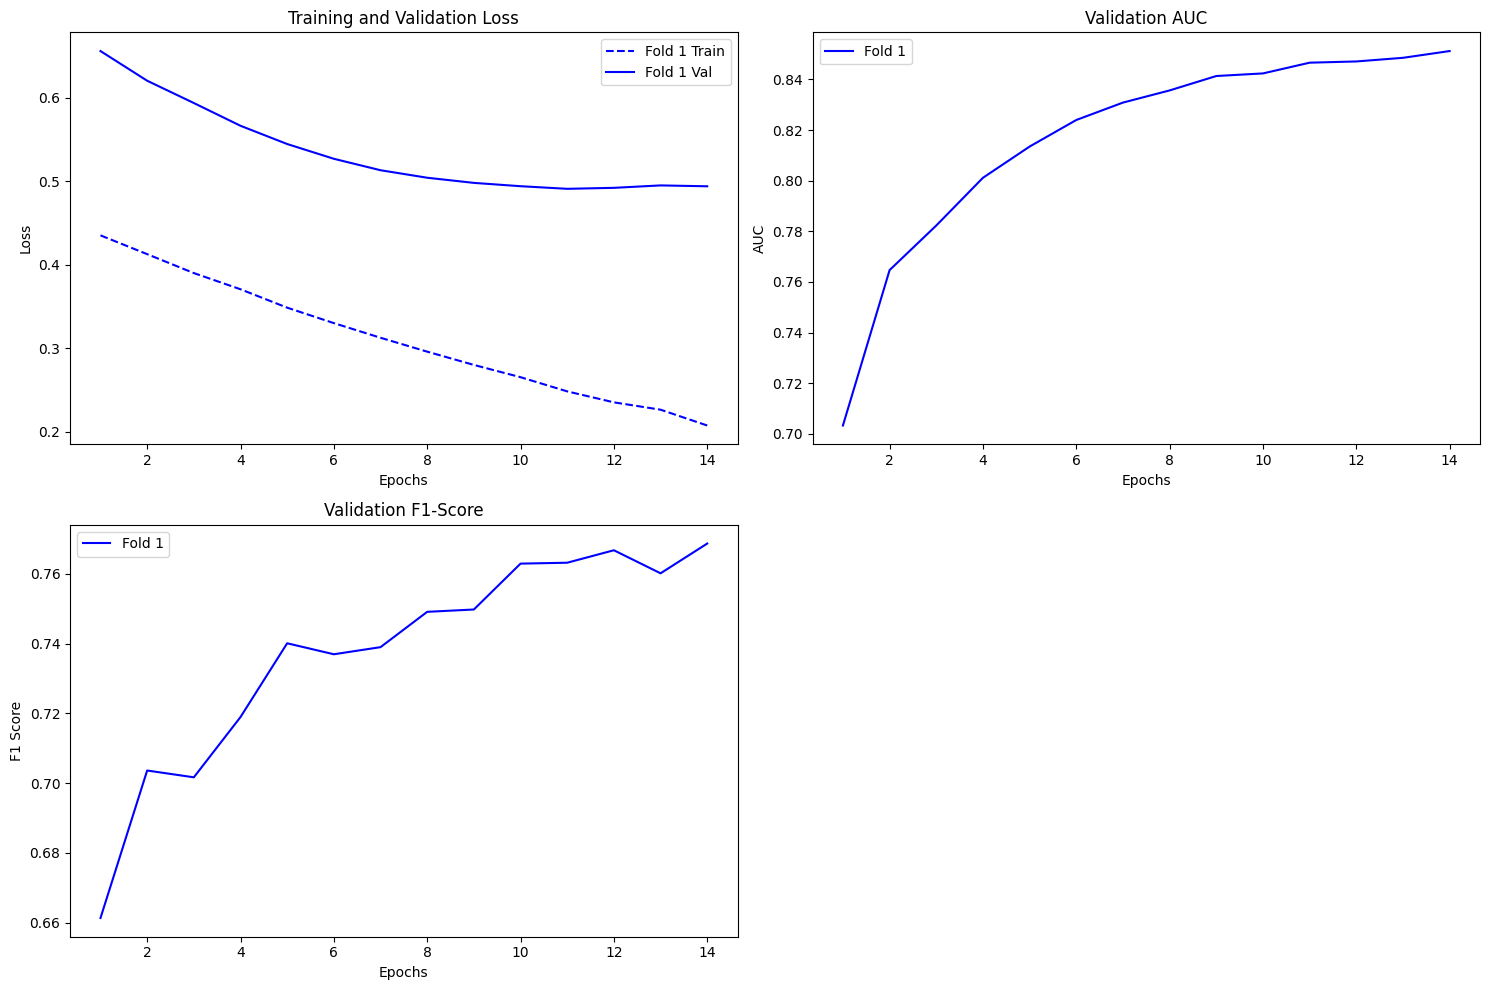

[codecarbon WARNING @ 00:07:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:07:28] [setup] RAM Tracking...
[codecarbon INFO @ 00:07:28] [setup] CPU Tracking...
[codecarbon WARNING @ 00:07:28] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 00:07:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 00:07:28] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 00:07:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:07:28] [setup] GPU Tracking...
[codecarbon INFO @ 00:07:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:07:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 2/5


[codecarbon INFO @ 00:08:03] Energy consumed for RAM : 0.028015 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:08:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:08:03] Energy consumed for All CPU : 0.031343 kWh
[codecarbon INFO @ 00:08:03] Energy consumed for all GPUs : 0.008852 kWh. Total GPU Power : 12.018672450001542 W
[codecarbon INFO @ 00:08:03] 0.068210 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:08:18] Energy consumed for RAM : 0.028173 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:08:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:08:18] Energy consumed for All CPU : 0.031520 kWh
[codecarbon INFO @ 00:08:18] Energy consumed for all GPUs : 0.008903 kWh. Total GPU Power : 12.084467252329805 W
[codecarbon INFO @ 00:08:18] 0.068595 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 1/100
Train Loss: 0.4380 | Val Loss: 0.6530
Val AUC: 0.7353, F1: 0.7180


[codecarbon INFO @ 00:11:18] Energy consumed for RAM : 0.030073 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:11:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:11:18] Energy consumed for All CPU : 0.033645 kWh
[codecarbon INFO @ 00:11:18] Energy consumed for all GPUs : 0.009505 kWh. Total GPU Power : 12.079955912865412 W
[codecarbon INFO @ 00:11:18] 0.073222 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:11:33] Energy consumed for RAM : 0.030231 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:11:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:11:33] Energy consumed for All CPU : 0.033822 kWh
[codecarbon INFO @ 00:11:33] Energy consumed for all GPUs : 0.009555 kWh. Total GPU Power : 12.076803878401938 W
[codecarbon INFO @ 00:11:33] 0.073607 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 2/100
Train Loss: 0.4139 | Val Loss: 0.6208
Val AUC: 0.7757, F1: 0.7278


[codecarbon INFO @ 00:14:18] Energy consumed for RAM : 0.031972 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:14:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:14:18] Energy consumed for All CPU : 0.035770 kWh
[codecarbon INFO @ 00:14:18] Energy consumed for all GPUs : 0.010103 kWh. Total GPU Power : 11.902851447519149 W
[codecarbon INFO @ 00:14:18] 0.077845 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:14:33] Energy consumed for RAM : 0.032130 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:14:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:14:33] Energy consumed for All CPU : 0.035947 kWh
[codecarbon INFO @ 00:14:33] Energy consumed for all GPUs : 0.010153 kWh. Total GPU Power : 11.941371314838788 W
[codecarbon INFO @ 00:14:33] 0.078230 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 3/100
Train Loss: 0.3919 | Val Loss: 0.5902
Val AUC: 0.7923, F1: 0.7408


[codecarbon INFO @ 00:17:33] Energy consumed for RAM : 0.034030 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:17:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:17:33] Energy consumed for All CPU : 0.038072 kWh
[codecarbon INFO @ 00:17:33] Energy consumed for all GPUs : 0.010751 kWh. Total GPU Power : 11.91349248316483 W
[codecarbon INFO @ 00:17:33] 0.082852 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:17:48] Energy consumed for RAM : 0.034188 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:17:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:17:48] Energy consumed for All CPU : 0.038249 kWh
[codecarbon INFO @ 00:17:48] Energy consumed for all GPUs : 0.010801 kWh. Total GPU Power : 11.93488739453888 W
[codecarbon INFO @ 00:17:48] 0.083237 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:17

Fold 2, Epoch 4/100
Train Loss: 0.3739 | Val Loss: 0.5666
Val AUC: 0.8027, F1: 0.7458


[codecarbon INFO @ 00:20:48] Energy consumed for RAM : 0.036087 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:20:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:20:48] Energy consumed for All CPU : 0.040374 kWh
[codecarbon INFO @ 00:20:48] Energy consumed for all GPUs : 0.011402 kWh. Total GPU Power : 11.950594094254173 W
[codecarbon INFO @ 00:20:48] 0.087863 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:21:03] Energy consumed for RAM : 0.036246 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:21:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:21:03] Energy consumed for All CPU : 0.040551 kWh
[codecarbon INFO @ 00:21:03] Energy consumed for all GPUs : 0.011452 kWh. Total GPU Power : 11.99352489554164 W
[codecarbon INFO @ 00:21:03] 0.088249 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:2

Fold 2, Epoch 5/100
Train Loss: 0.3527 | Val Loss: 0.5454
Val AUC: 0.8121, F1: 0.7424


[codecarbon INFO @ 00:23:48] Energy consumed for RAM : 0.037987 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:23:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:23:48] Energy consumed for All CPU : 0.042499 kWh
[codecarbon INFO @ 00:23:48] Energy consumed for all GPUs : 0.012004 kWh. Total GPU Power : 12.006507032108184 W
[codecarbon INFO @ 00:23:48] 0.092489 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:23:48] 0.002525 g.CO2eq/s mean an estimation of 79.63730292163902 kg.CO2eq/year
[codecarbon INFO @ 00:24:03] Energy consumed for RAM : 0.038145 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:24:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:24:03] Energy consumed for All CPU : 0.042676 kWh
[codecarbon INFO @ 00:24:03] Energy consumed for all GPUs : 0.012055 kWh. Total GPU Power : 12.243244201745533 W
[codecarbon INFO @ 00:24:03] 0.0

Fold 2, Epoch 6/100
Train Loss: 0.3348 | Val Loss: 0.5255
Val AUC: 0.8255, F1: 0.7579


[codecarbon INFO @ 00:27:03] Energy consumed for RAM : 0.040044 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:27:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:03] Energy consumed for All CPU : 0.044800 kWh
[codecarbon INFO @ 00:27:03] Energy consumed for all GPUs : 0.012657 kWh. Total GPU Power : 11.939405084284916 W
[codecarbon INFO @ 00:27:03] 0.097501 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:27:18] Energy consumed for RAM : 0.040202 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:27:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:18] Energy consumed for All CPU : 0.044978 kWh
[codecarbon INFO @ 00:27:18] Energy consumed for all GPUs : 0.012707 kWh. Total GPU Power : 12.004795046169614 W
[codecarbon INFO @ 00:27:18] 0.097887 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 7/100
Train Loss: 0.3164 | Val Loss: 0.5091
Val AUC: 0.8325, F1: 0.7619


[codecarbon INFO @ 00:30:03] Energy consumed for RAM : 0.041943 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:30:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:30:03] Energy consumed for All CPU : 0.046925 kWh
[codecarbon INFO @ 00:30:03] Energy consumed for all GPUs : 0.013251 kWh. Total GPU Power : 11.676941219083792 W
[codecarbon INFO @ 00:30:03] 0.102119 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:30:18] Energy consumed for RAM : 0.042101 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:30:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:30:18] Energy consumed for All CPU : 0.047102 kWh
[codecarbon INFO @ 00:30:18] Energy consumed for all GPUs : 0.013300 kWh. Total GPU Power : 11.771617976023611 W
[codecarbon INFO @ 00:30:18] 0.102504 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 8/100
Train Loss: 0.3037 | Val Loss: 0.4949
Val AUC: 0.8407, F1: 0.7622


[codecarbon INFO @ 00:33:18] Energy consumed for RAM : 0.044001 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:33:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:18] Energy consumed for All CPU : 0.049227 kWh
[codecarbon INFO @ 00:33:18] Energy consumed for all GPUs : 0.013891 kWh. Total GPU Power : 10.849992192171644 W
[codecarbon INFO @ 00:33:18] 0.107119 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:33:33] Energy consumed for RAM : 0.044159 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:33:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:33] Energy consumed for All CPU : 0.049404 kWh
[codecarbon INFO @ 00:33:33] Energy consumed for all GPUs : 0.013937 kWh. Total GPU Power : 10.947482520355525 W
[codecarbon INFO @ 00:33:33] 0.107500 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 9/100
Train Loss: 0.2895 | Val Loss: 0.4849
Val AUC: 0.8476, F1: 0.7680


[codecarbon INFO @ 00:36:34] Energy consumed for RAM : 0.046058 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:36:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:34] Energy consumed for All CPU : 0.051529 kWh
[codecarbon INFO @ 00:36:34] Energy consumed for all GPUs : 0.014483 kWh. Total GPU Power : 10.99099109182808 W
[codecarbon INFO @ 00:36:34] 0.112070 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:36:49] Energy consumed for RAM : 0.046216 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:36:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:49] Energy consumed for All CPU : 0.051706 kWh
[codecarbon INFO @ 00:36:49] Energy consumed for all GPUs : 0.014530 kWh. Total GPU Power : 11.254478242409077 W
[codecarbon INFO @ 00:36:49] 0.112452 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:3

Fold 2, Epoch 10/100
Train Loss: 0.2737 | Val Loss: 0.4798
Val AUC: 0.8515, F1: 0.7769


[codecarbon INFO @ 00:39:34] Energy consumed for RAM : 0.047957 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:39:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:34] Energy consumed for All CPU : 0.053654 kWh
[codecarbon INFO @ 00:39:34] Energy consumed for all GPUs : 0.015040 kWh. Total GPU Power : 11.15121541264737 W
[codecarbon INFO @ 00:39:34] 0.116651 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:39:49] Energy consumed for RAM : 0.048115 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:39:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:49] Energy consumed for All CPU : 0.053831 kWh
[codecarbon INFO @ 00:39:49] Energy consumed for all GPUs : 0.015087 kWh. Total GPU Power : 11.157082552273753 W
[codecarbon INFO @ 00:39:49] 0.117033 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:3

Fold 2, Epoch 11/100
Train Loss: 0.2571 | Val Loss: 0.4707
Val AUC: 0.8559, F1: 0.7844


[codecarbon INFO @ 00:42:49] Energy consumed for RAM : 0.050014 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:42:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:49] Energy consumed for All CPU : 0.055955 kWh
[codecarbon INFO @ 00:42:49] Energy consumed for all GPUs : 0.015641 kWh. Total GPU Power : 11.14490789716227 W
[codecarbon INFO @ 00:42:49] 0.121611 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:43:04] Energy consumed for RAM : 0.050172 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:43:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:04] Energy consumed for All CPU : 0.056132 kWh
[codecarbon INFO @ 00:43:04] Energy consumed for all GPUs : 0.015689 kWh. Total GPU Power : 11.333687681364044 W
[codecarbon INFO @ 00:43:04] 0.121993 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:4

Fold 2, Epoch 12/100
Train Loss: 0.2428 | Val Loss: 0.4731
Val AUC: 0.8565, F1: 0.7839


[codecarbon INFO @ 00:45:49] Energy consumed for RAM : 0.051913 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:45:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:49] Energy consumed for All CPU : 0.058080 kWh
[codecarbon INFO @ 00:45:49] Energy consumed for all GPUs : 0.016201 kWh. Total GPU Power : 11.051459805811378 W
[codecarbon INFO @ 00:45:49] 0.126194 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:45:49] 0.002503 g.CO2eq/s mean an estimation of 78.92087158529912 kg.CO2eq/year
[codecarbon INFO @ 00:46:04] Energy consumed for RAM : 0.052072 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:46:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:04] Energy consumed for All CPU : 0.058257 kWh
[codecarbon INFO @ 00:46:04] Energy consumed for all GPUs : 0.016247 kWh. Total GPU Power : 11.114308135635723 W
[codecarbon INFO @ 00:46:04] 0.1

Fold 2, Epoch 13/100
Train Loss: 0.2249 | Val Loss: 0.4730
Val AUC: 0.8584, F1: 0.7872


[codecarbon INFO @ 00:49:04] Energy consumed for RAM : 0.053970 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:49:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:04] Energy consumed for All CPU : 0.060382 kWh
[codecarbon INFO @ 00:49:04] Energy consumed for all GPUs : 0.016802 kWh. Total GPU Power : 11.008250489664656 W
[codecarbon INFO @ 00:49:04] 0.131154 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:49:19] Energy consumed for RAM : 0.054128 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:49:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:19] Energy consumed for All CPU : 0.060558 kWh
[codecarbon INFO @ 00:49:19] Energy consumed for all GPUs : 0.016848 kWh. Total GPU Power : 11.122959544848078 W
[codecarbon INFO @ 00:49:19] 0.131535 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 2, Epoch 14/100
Train Loss: 0.2145 | Val Loss: 0.4765
Val AUC: 0.8577, F1: 0.7788
Early stopping at epoch 14


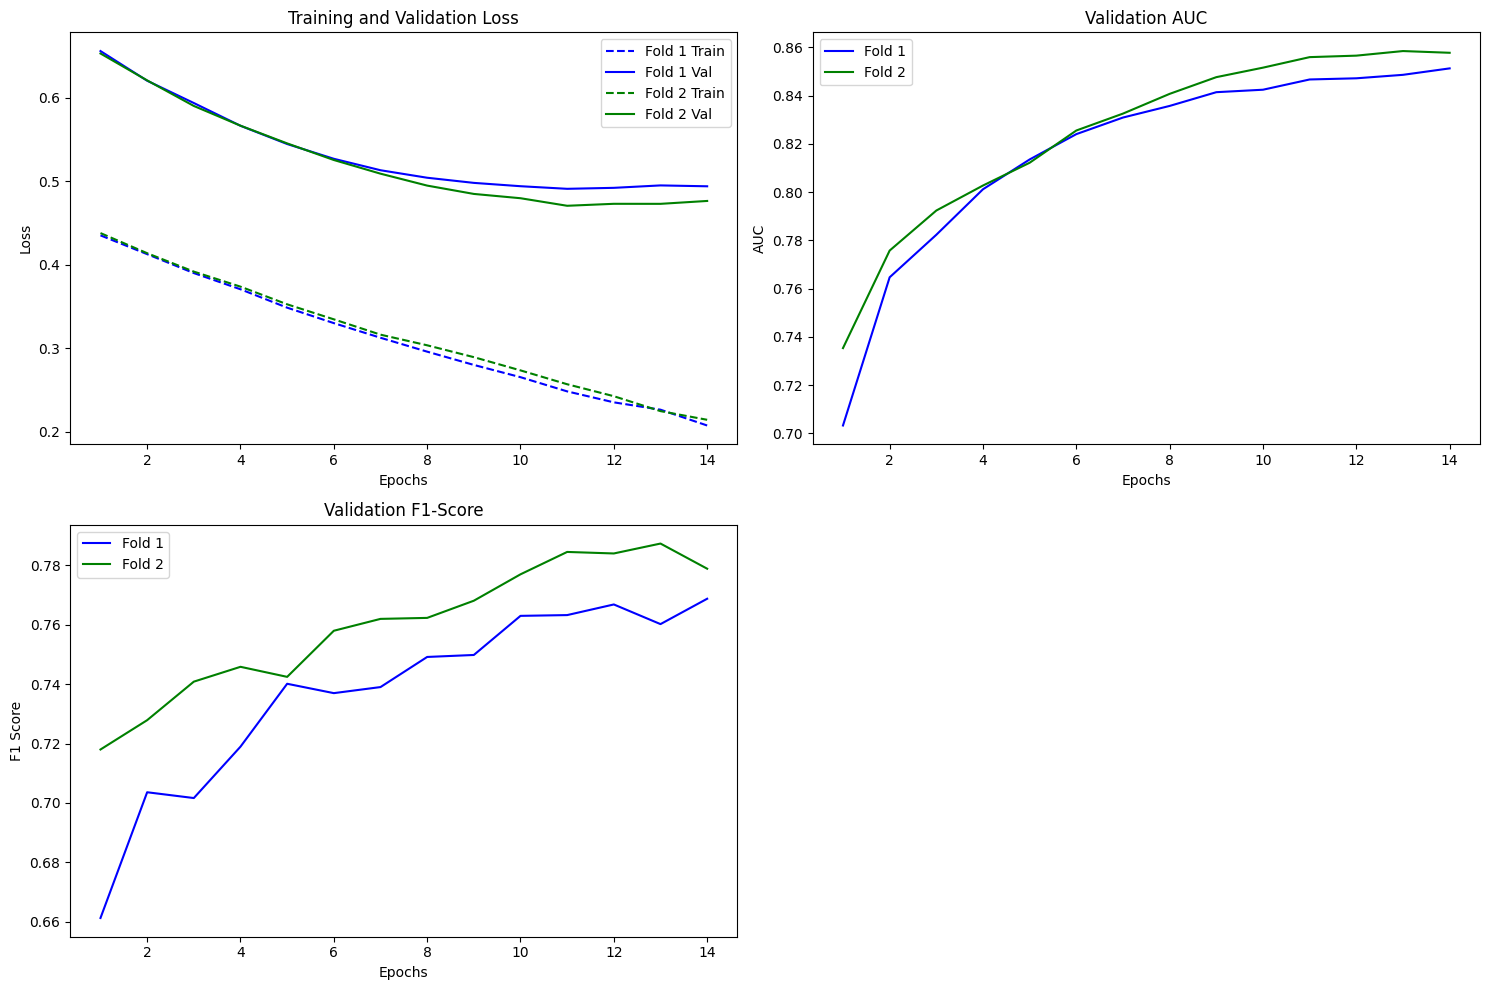

[codecarbon WARNING @ 00:52:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:52:05] [setup] RAM Tracking...
[codecarbon INFO @ 00:52:05] [setup] CPU Tracking...
[codecarbon WARNING @ 00:52:05] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 00:52:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 00:52:05] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 00:52:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:52:05] [setup] GPU Tracking...
[codecarbon INFO @ 00:52:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:52:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 3/5


[codecarbon INFO @ 00:52:34] Energy consumed for RAM : 0.056187 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:52:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:34] Energy consumed for All CPU : 0.062861 kWh
[codecarbon INFO @ 00:52:34] Energy consumed for all GPUs : 0.017451 kWh. Total GPU Power : 11.039732056177137 W
[codecarbon INFO @ 00:52:34] 0.136498 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:52:49] Energy consumed for RAM : 0.056345 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:52:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:49] Energy consumed for All CPU : 0.063038 kWh
[codecarbon INFO @ 00:52:49] Energy consumed for all GPUs : 0.017498 kWh. Total GPU Power : 11.224998032523263 W
[codecarbon INFO @ 00:52:49] 0.136880 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 3, Epoch 1/100
Train Loss: 0.4355 | Val Loss: 0.6632
Val AUC: 0.6811, F1: 0.6687


[codecarbon INFO @ 00:55:49] Energy consumed for RAM : 0.058244 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:55:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:49] Energy consumed for All CPU : 0.065163 kWh
[codecarbon INFO @ 00:55:49] Energy consumed for all GPUs : 0.018053 kWh. Total GPU Power : 10.91548718713123 W
[codecarbon INFO @ 00:55:49] 0.141459 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:55:49] 0.002499 g.CO2eq/s mean an estimation of 78.81277938355458 kg.CO2eq/year
[codecarbon INFO @ 00:56:04] Energy consumed for RAM : 0.058402 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:56:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:04] Energy consumed for All CPU : 0.065340 kWh
[codecarbon INFO @ 00:56:04] Energy consumed for all GPUs : 0.018099 kWh. Total GPU Power : 11.041323894136573 W
[codecarbon INFO @ 00:56:04] 0.14

Fold 3, Epoch 2/100
Train Loss: 0.4154 | Val Loss: 0.6358
Val AUC: 0.7309, F1: 0.6994


[codecarbon INFO @ 00:59:04] Energy consumed for RAM : 0.060301 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:59:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:04] Energy consumed for All CPU : 0.067464 kWh
[codecarbon INFO @ 00:59:04] Energy consumed for all GPUs : 0.018646 kWh. Total GPU Power : 10.890099478980057 W
[codecarbon INFO @ 00:59:04] 0.146411 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:59:19] Energy consumed for RAM : 0.060459 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 00:59:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:19] Energy consumed for All CPU : 0.067641 kWh
[codecarbon INFO @ 00:59:19] Energy consumed for all GPUs : 0.018691 kWh. Total GPU Power : 11.015151509202765 W
[codecarbon INFO @ 00:59:19] 0.146792 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:

Fold 3, Epoch 3/100
Train Loss: 0.3915 | Val Loss: 0.6067
Val AUC: 0.7586, F1: 0.7074


[codecarbon INFO @ 01:02:04] Energy consumed for RAM : 0.062200 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:02:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:04] Energy consumed for All CPU : 0.069589 kWh
[codecarbon INFO @ 01:02:04] Energy consumed for all GPUs : 0.019199 kWh. Total GPU Power : 10.956437626050898 W
[codecarbon INFO @ 01:02:04] 0.150988 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:02:19] Energy consumed for RAM : 0.062358 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:02:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:19] Energy consumed for All CPU : 0.069766 kWh
[codecarbon INFO @ 01:02:19] Energy consumed for all GPUs : 0.019245 kWh. Total GPU Power : 11.068829956986477 W
[codecarbon INFO @ 01:02:19] 0.151370 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 4/100
Train Loss: 0.3727 | Val Loss: 0.5843
Val AUC: 0.7741, F1: 0.7179


[codecarbon INFO @ 01:05:19] Energy consumed for RAM : 0.064257 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:05:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:19] Energy consumed for All CPU : 0.071890 kWh
[codecarbon INFO @ 01:05:19] Energy consumed for all GPUs : 0.019794 kWh. Total GPU Power : 10.995133261782614 W
[codecarbon INFO @ 01:05:19] 0.155942 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:05:34] Energy consumed for RAM : 0.064415 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:05:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:34] Energy consumed for All CPU : 0.072068 kWh
[codecarbon INFO @ 01:05:34] Energy consumed for all GPUs : 0.019841 kWh. Total GPU Power : 11.282868886001618 W
[codecarbon INFO @ 01:05:34] 0.156324 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 5/100
Train Loss: 0.3522 | Val Loss: 0.5641
Val AUC: 0.7877, F1: 0.7210


[codecarbon INFO @ 01:08:34] Energy consumed for RAM : 0.066314 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:08:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:35] Energy consumed for All CPU : 0.074192 kWh
[codecarbon INFO @ 01:08:35] Energy consumed for all GPUs : 0.020397 kWh. Total GPU Power : 11.075486233544767 W
[codecarbon INFO @ 01:08:35] 0.160904 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:08:49] Energy consumed for RAM : 0.066472 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:08:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:50] Energy consumed for All CPU : 0.074369 kWh
[codecarbon INFO @ 01:08:50] Energy consumed for all GPUs : 0.020444 kWh. Total GPU Power : 11.388115714156154 W
[codecarbon INFO @ 01:08:50] 0.161286 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 6/100
Train Loss: 0.3341 | Val Loss: 0.5475
Val AUC: 0.7997, F1: 0.7271


[codecarbon INFO @ 01:11:35] Energy consumed for RAM : 0.068213 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:11:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:35] Energy consumed for All CPU : 0.076317 kWh
[codecarbon INFO @ 01:11:35] Energy consumed for all GPUs : 0.020956 kWh. Total GPU Power : 11.196791723047234 W
[codecarbon INFO @ 01:11:35] 0.165487 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:11:50] Energy consumed for RAM : 0.068371 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:11:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:50] Energy consumed for All CPU : 0.076494 kWh
[codecarbon INFO @ 01:11:50] Energy consumed for all GPUs : 0.021003 kWh. Total GPU Power : 11.120854739176352 W
[codecarbon INFO @ 01:11:50] 0.165868 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 7/100
Train Loss: 0.3137 | Val Loss: 0.5338
Val AUC: 0.8073, F1: 0.7249


[codecarbon INFO @ 01:14:50] Energy consumed for RAM : 0.070270 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:14:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:50] Energy consumed for All CPU : 0.078619 kWh
[codecarbon INFO @ 01:14:50] Energy consumed for all GPUs : 0.021561 kWh. Total GPU Power : 10.996083286883136 W
[codecarbon INFO @ 01:14:50] 0.170451 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:15:05] Energy consumed for RAM : 0.070429 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:15:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:05] Energy consumed for All CPU : 0.078796 kWh
[codecarbon INFO @ 01:15:05] Energy consumed for all GPUs : 0.021608 kWh. Total GPU Power : 11.146127202407559 W
[codecarbon INFO @ 01:15:05] 0.170833 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 8/100
Train Loss: 0.2987 | Val Loss: 0.5193
Val AUC: 0.8166, F1: 0.7309


[codecarbon INFO @ 01:17:50] Energy consumed for RAM : 0.072170 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:17:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:50] Energy consumed for All CPU : 0.080744 kWh
[codecarbon INFO @ 01:17:50] Energy consumed for all GPUs : 0.022116 kWh. Total GPU Power : 11.034104865370683 W
[codecarbon INFO @ 01:17:50] 0.175029 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:17:50] 0.002500 g.CO2eq/s mean an estimation of 78.83084873606897 kg.CO2eq/year
[codecarbon INFO @ 01:18:05] Energy consumed for RAM : 0.072328 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:18:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:05] Energy consumed for All CPU : 0.080921 kWh
[codecarbon INFO @ 01:18:05] Energy consumed for all GPUs : 0.022162 kWh. Total GPU Power : 10.995965679165806 W
[codecarbon INFO @ 01:18:05] 0.1

Fold 3, Epoch 9/100
Train Loss: 0.2804 | Val Loss: 0.5148
Val AUC: 0.8212, F1: 0.7380


[codecarbon INFO @ 01:21:05] Energy consumed for RAM : 0.074227 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:21:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:21:05] Energy consumed for All CPU : 0.083045 kWh
[codecarbon INFO @ 01:21:05] Energy consumed for all GPUs : 0.022716 kWh. Total GPU Power : 10.987789829453332 W
[codecarbon INFO @ 01:21:05] 0.179989 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:21:20] Energy consumed for RAM : 0.074386 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:21:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:21:20] Energy consumed for All CPU : 0.083223 kWh
[codecarbon INFO @ 01:21:20] Energy consumed for all GPUs : 0.022763 kWh. Total GPU Power : 11.194209145294854 W
[codecarbon INFO @ 01:21:20] 0.180371 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 10/100
Train Loss: 0.2683 | Val Loss: 0.5047
Val AUC: 0.8294, F1: 0.7466


[codecarbon INFO @ 01:24:05] Energy consumed for RAM : 0.076126 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:24:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:24:05] Energy consumed for All CPU : 0.085170 kWh
[codecarbon INFO @ 01:24:05] Energy consumed for all GPUs : 0.023271 kWh. Total GPU Power : 11.142990389777543 W
[codecarbon INFO @ 01:24:05] 0.184568 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:24:20] Energy consumed for RAM : 0.076284 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:24:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:24:20] Energy consumed for All CPU : 0.085347 kWh
[codecarbon INFO @ 01:24:20] Energy consumed for all GPUs : 0.023317 kWh. Total GPU Power : 11.049549327873429 W
[codecarbon INFO @ 01:24:20] 0.184949 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 11/100
Train Loss: 0.2543 | Val Loss: 0.5009
Val AUC: 0.8331, F1: 0.7439


[codecarbon INFO @ 01:27:20] Energy consumed for RAM : 0.078184 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:27:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:27:20] Energy consumed for All CPU : 0.087472 kWh
[codecarbon INFO @ 01:27:20] Energy consumed for all GPUs : 0.023870 kWh. Total GPU Power : 11.133453039663447 W
[codecarbon INFO @ 01:27:20] 0.189526 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:27:35] Energy consumed for RAM : 0.078342 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:27:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:27:35] Energy consumed for All CPU : 0.087649 kWh
[codecarbon INFO @ 01:27:35] Energy consumed for all GPUs : 0.023916 kWh. Total GPU Power : 10.90327677509814 W
[codecarbon INFO @ 01:27:35] 0.189907 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:2

Fold 3, Epoch 12/100
Train Loss: 0.2408 | Val Loss: 0.4990
Val AUC: 0.8366, F1: 0.7548


[codecarbon INFO @ 01:30:20] Energy consumed for RAM : 0.080083 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:30:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:30:20] Energy consumed for All CPU : 0.089597 kWh
[codecarbon INFO @ 01:30:20] Energy consumed for all GPUs : 0.024418 kWh. Total GPU Power : 10.96137344300696 W
[codecarbon INFO @ 01:30:20] 0.194098 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:30:35] Energy consumed for RAM : 0.080241 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:30:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:30:35] Energy consumed for All CPU : 0.089774 kWh
[codecarbon INFO @ 01:30:35] Energy consumed for all GPUs : 0.024464 kWh. Total GPU Power : 11.072648297416068 W
[codecarbon INFO @ 01:30:35] 0.194479 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:3

Fold 3, Epoch 13/100
Train Loss: 0.2280 | Val Loss: 0.4975
Val AUC: 0.8387, F1: 0.7483


[codecarbon INFO @ 01:33:35] Energy consumed for RAM : 0.082141 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:33:35] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 01:33:35] Energy consumed for All CPU : 0.091899 kWh
[codecarbon INFO @ 01:33:35] Energy consumed for all GPUs : 0.025020 kWh. Total GPU Power : 11.08586592052289 W
[codecarbon INFO @ 01:33:35] 0.199060 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:33:50] Energy consumed for RAM : 0.082299 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:33:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:33:50] Energy consumed for All CPU : 0.092076 kWh
[codecarbon INFO @ 01:33:50] Energy consumed for all GPUs : 0.025066 kWh. Total GPU Power : 11.145062986890991 W
[codecarbon INFO @ 01:33:50] 0.199440 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:3

Fold 3, Epoch 14/100
Train Loss: 0.2090 | Val Loss: 0.4979
Val AUC: 0.8414, F1: 0.7572


[codecarbon INFO @ 01:36:50] Energy consumed for RAM : 0.084198 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:36:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:36:50] Energy consumed for All CPU : 0.094200 kWh
[codecarbon INFO @ 01:36:50] Energy consumed for all GPUs : 0.025613 kWh. Total GPU Power : 11.053911101392453 W
[codecarbon INFO @ 01:36:50] 0.204011 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:37:05] Energy consumed for RAM : 0.084356 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:37:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:37:05] Energy consumed for All CPU : 0.094377 kWh
[codecarbon INFO @ 01:37:05] Energy consumed for all GPUs : 0.025659 kWh. Total GPU Power : 11.070923214642528 W
[codecarbon INFO @ 01:37:05] 0.204392 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 3, Epoch 15/100
Train Loss: 0.1993 | Val Loss: 0.4998
Val AUC: 0.8426, F1: 0.7648


[codecarbon INFO @ 01:39:50] Energy consumed for RAM : 0.086097 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:39:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:39:50] Energy consumed for All CPU : 0.096325 kWh
[codecarbon INFO @ 01:39:50] Energy consumed for all GPUs : 0.026159 kWh. Total GPU Power : 10.826212850242227 W
[codecarbon INFO @ 01:39:50] 0.208581 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:39:51] 0.002494 g.CO2eq/s mean an estimation of 78.65927512162257 kg.CO2eq/year
[codecarbon INFO @ 01:40:05] Energy consumed for RAM : 0.086255 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:40:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:40:05] Energy consumed for All CPU : 0.096502 kWh
[codecarbon INFO @ 01:40:05] Energy consumed for all GPUs : 0.026206 kWh. Total GPU Power : 11.160180846164826 W
[codecarbon INFO @ 01:40:05] 0.2

Fold 3, Epoch 16/100
Train Loss: 0.1897 | Val Loss: 0.5036
Val AUC: 0.8429, F1: 0.7587
Early stopping at epoch 16


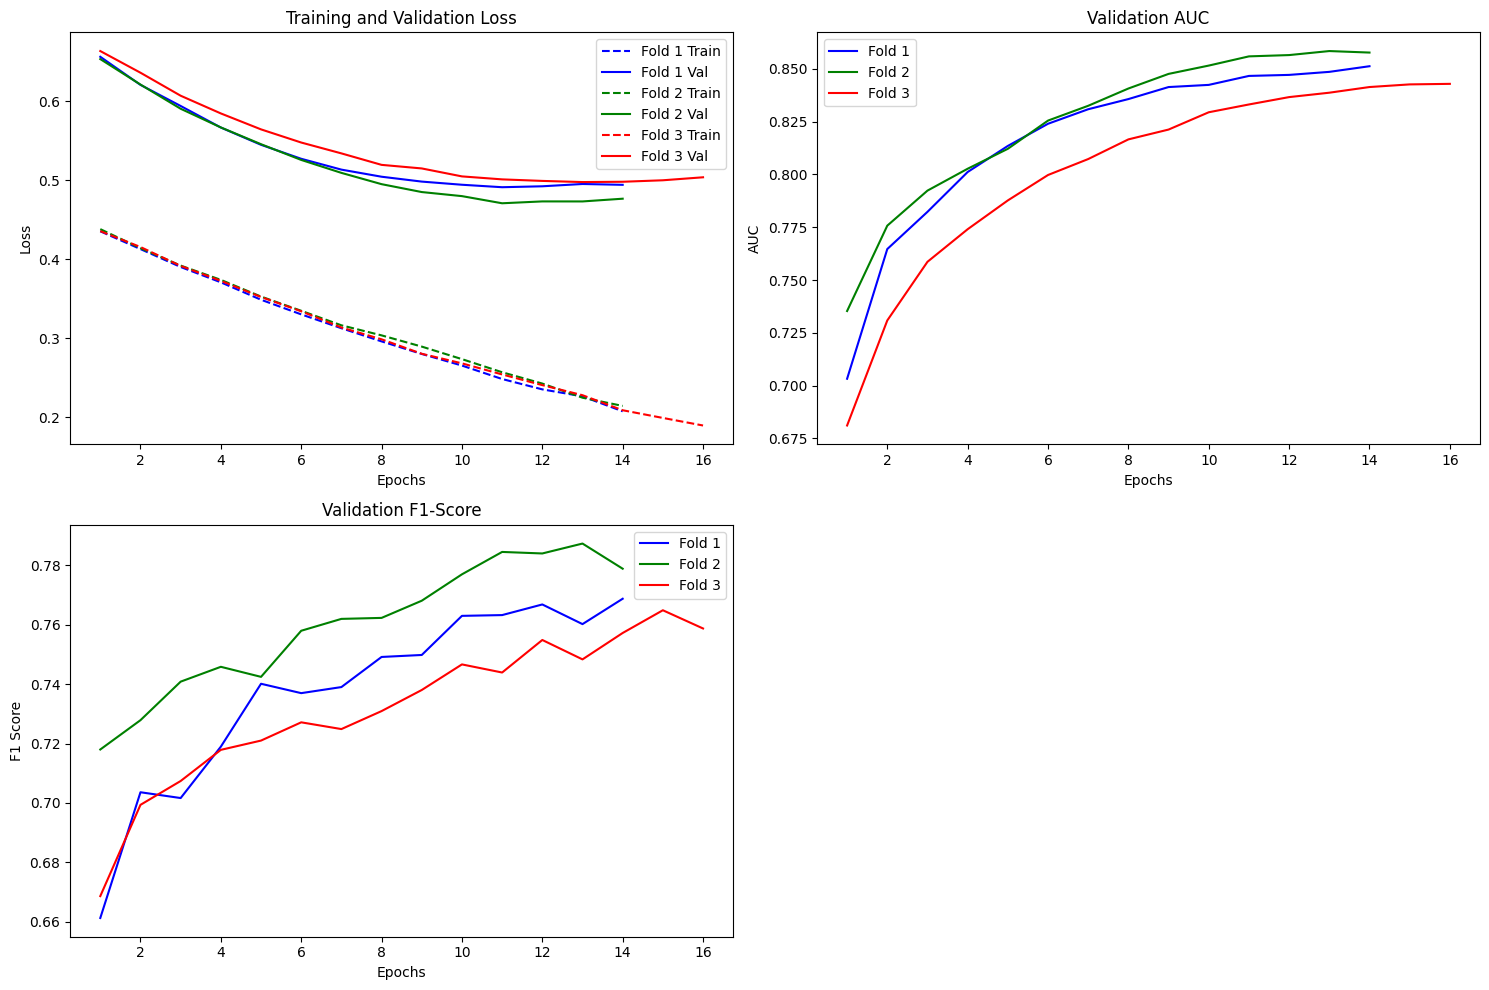

[codecarbon WARNING @ 01:42:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:42:55] [setup] RAM Tracking...
[codecarbon INFO @ 01:42:55] [setup] CPU Tracking...
[codecarbon WARNING @ 01:42:55] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 01:42:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 01:42:55] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 01:42:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:42:55] [setup] GPU Tracking...
[codecarbon INFO @ 01:42:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:42:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 4/5


[codecarbon INFO @ 01:43:36] Energy consumed for RAM : 0.088471 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:43:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:43:36] Energy consumed for All CPU : 0.098981 kWh
[codecarbon INFO @ 01:43:36] Energy consumed for all GPUs : 0.026856 kWh. Total GPU Power : 11.075438076221776 W
[codecarbon INFO @ 01:43:36] 0.214307 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:43:51] Energy consumed for RAM : 0.088629 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:43:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:43:51] Energy consumed for All CPU : 0.099158 kWh
[codecarbon INFO @ 01:43:51] Energy consumed for all GPUs : 0.026902 kWh. Total GPU Power : 11.099041799557225 W
[codecarbon INFO @ 01:43:51] 0.214689 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 4, Epoch 1/100
Train Loss: 0.4366 | Val Loss: 0.6526
Val AUC: 0.7213, F1: 0.6164


[codecarbon INFO @ 01:46:36] Energy consumed for RAM : 0.090370 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:46:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:46:36] Energy consumed for All CPU : 0.101105 kWh
[codecarbon INFO @ 01:46:36] Energy consumed for all GPUs : 0.027412 kWh. Total GPU Power : 11.131666590023846 W
[codecarbon INFO @ 01:46:36] 0.218887 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:46:51] Energy consumed for RAM : 0.090528 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:46:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:46:51] Energy consumed for All CPU : 0.101283 kWh
[codecarbon INFO @ 01:46:51] Energy consumed for all GPUs : 0.027458 kWh. Total GPU Power : 11.13461191184685 W
[codecarbon INFO @ 01:46:51] 0.219269 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:4

Fold 4, Epoch 2/100
Train Loss: 0.4139 | Val Loss: 0.6229
Val AUC: 0.7630, F1: 0.6636


[codecarbon INFO @ 01:49:51] Energy consumed for RAM : 0.092427 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:49:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:49:51] Energy consumed for All CPU : 0.103408 kWh
[codecarbon INFO @ 01:49:51] Energy consumed for all GPUs : 0.028016 kWh. Total GPU Power : 11.07632910856263 W
[codecarbon INFO @ 01:49:51] 0.223851 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:49:51] 0.002500 g.CO2eq/s mean an estimation of 78.85142439253353 kg.CO2eq/year
[codecarbon INFO @ 01:50:06] Energy consumed for RAM : 0.092585 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:50:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:50:06] Energy consumed for All CPU : 0.103584 kWh
[codecarbon INFO @ 01:50:06] Energy consumed for all GPUs : 0.028062 kWh. Total GPU Power : 11.015704646253809 W
[codecarbon INFO @ 01:50:06] 0.22

Fold 4, Epoch 3/100
Train Loss: 0.3929 | Val Loss: 0.5952
Val AUC: 0.7789, F1: 0.6835


[codecarbon INFO @ 01:52:51] Energy consumed for RAM : 0.094326 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:52:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:52:51] Energy consumed for All CPU : 0.105532 kWh
[codecarbon INFO @ 01:52:51] Energy consumed for all GPUs : 0.028569 kWh. Total GPU Power : 10.885240452880254 W
[codecarbon INFO @ 01:52:51] 0.228427 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:53:06] Energy consumed for RAM : 0.094484 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:53:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:53:06] Energy consumed for All CPU : 0.105709 kWh
[codecarbon INFO @ 01:53:06] Energy consumed for all GPUs : 0.028615 kWh. Total GPU Power : 11.071759603075753 W
[codecarbon INFO @ 01:53:06] 0.228809 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 4, Epoch 4/100
Train Loss: 0.3710 | Val Loss: 0.5689
Val AUC: 0.7957, F1: 0.7140


[codecarbon INFO @ 01:56:06] Energy consumed for RAM : 0.096383 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:56:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:56:06] Energy consumed for All CPU : 0.107834 kWh
[codecarbon INFO @ 01:56:06] Energy consumed for all GPUs : 0.029170 kWh. Total GPU Power : 10.893354678837753 W
[codecarbon INFO @ 01:56:06] 0.233387 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:56:21] Energy consumed for RAM : 0.096541 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:56:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:56:21] Energy consumed for All CPU : 0.108011 kWh
[codecarbon INFO @ 01:56:21] Energy consumed for all GPUs : 0.029215 kWh. Total GPU Power : 10.926928458316274 W
[codecarbon INFO @ 01:56:21] 0.233768 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:

Fold 4, Epoch 5/100
Train Loss: 0.3529 | Val Loss: 0.5473
Val AUC: 0.8069, F1: 0.7214


[codecarbon INFO @ 01:59:06] Energy consumed for RAM : 0.098282 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:59:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:59:06] Energy consumed for All CPU : 0.109959 kWh
[codecarbon INFO @ 01:59:06] Energy consumed for all GPUs : 0.029719 kWh. Total GPU Power : 10.80388153755084 W
[codecarbon INFO @ 01:59:06] 0.237960 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:59:21] Energy consumed for RAM : 0.098441 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 01:59:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:59:21] Energy consumed for All CPU : 0.110136 kWh
[codecarbon INFO @ 01:59:21] Energy consumed for all GPUs : 0.029765 kWh. Total GPU Power : 11.048440879658301 W
[codecarbon INFO @ 01:59:21] 0.238342 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:5

Fold 4, Epoch 6/100
Train Loss: 0.3317 | Val Loss: 0.5321
Val AUC: 0.8147, F1: 0.7214


[codecarbon INFO @ 02:02:21] Energy consumed for RAM : 0.100340 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:02:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:02:21] Energy consumed for All CPU : 0.112261 kWh
[codecarbon INFO @ 02:02:21] Energy consumed for all GPUs : 0.030313 kWh. Total GPU Power : 10.888080837707644 W
[codecarbon INFO @ 02:02:21] 0.242914 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:02:36] Energy consumed for RAM : 0.100498 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:02:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:02:36] Energy consumed for All CPU : 0.112438 kWh
[codecarbon INFO @ 02:02:36] Energy consumed for all GPUs : 0.030358 kWh. Total GPU Power : 10.760984298765612 W
[codecarbon INFO @ 02:02:36] 0.243294 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 7/100
Train Loss: 0.3166 | Val Loss: 0.5225
Val AUC: 0.8199, F1: 0.7425


[codecarbon INFO @ 02:05:21] Energy consumed for RAM : 0.102239 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:05:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:05:21] Energy consumed for All CPU : 0.114385 kWh
[codecarbon INFO @ 02:05:21] Energy consumed for all GPUs : 0.030853 kWh. Total GPU Power : 10.847084838941436 W
[codecarbon INFO @ 02:05:21] 0.247477 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:05:36] Energy consumed for RAM : 0.102397 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:05:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:05:36] Energy consumed for All CPU : 0.114562 kWh
[codecarbon INFO @ 02:05:36] Energy consumed for all GPUs : 0.030899 kWh. Total GPU Power : 11.069456803611713 W
[codecarbon INFO @ 02:05:36] 0.247858 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 8/100
Train Loss: 0.3017 | Val Loss: 0.5124
Val AUC: 0.8255, F1: 0.7433


[codecarbon INFO @ 02:08:36] Energy consumed for RAM : 0.104297 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:08:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:08:36] Energy consumed for All CPU : 0.116687 kWh
[codecarbon INFO @ 02:08:36] Energy consumed for all GPUs : 0.031435 kWh. Total GPU Power : 10.805236690074437 W
[codecarbon INFO @ 02:08:36] 0.252419 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:08:51] Energy consumed for RAM : 0.104455 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:08:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:08:51] Energy consumed for All CPU : 0.116864 kWh
[codecarbon INFO @ 02:08:51] Energy consumed for all GPUs : 0.031481 kWh. Total GPU Power : 10.943211563150594 W
[codecarbon INFO @ 02:08:51] 0.252801 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 9/100
Train Loss: 0.2847 | Val Loss: 0.5104
Val AUC: 0.8278, F1: 0.7316


[codecarbon INFO @ 02:11:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:11:36] Energy consumed for All CPU : 0.118812 kWh
[codecarbon INFO @ 02:11:36] Energy consumed for all GPUs : 0.031975 kWh. Total GPU Power : 10.595929370661043 W
[codecarbon INFO @ 02:11:36] 0.256983 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:11:51] Energy consumed for RAM : 0.106354 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:11:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:11:51] Energy consumed for All CPU : 0.118989 kWh
[codecarbon INFO @ 02:11:51] Energy consumed for all GPUs : 0.032021 kWh. Total GPU Power : 10.927151444884357 W
[codecarbon INFO @ 02:11:51] 0.257363 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:11:51] 0.002491 g.CO2eq/s mean an estimation of 78.55212949409112 kg.CO2eq/year
[codecar

Fold 4, Epoch 10/100
Train Loss: 0.2705 | Val Loss: 0.5027
Val AUC: 0.8340, F1: 0.7326


[codecarbon INFO @ 02:15:07] Energy consumed for RAM : 0.108412 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:15:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:15:07] Energy consumed for All CPU : 0.121291 kWh
[codecarbon INFO @ 02:15:07] Energy consumed for all GPUs : 0.032606 kWh. Total GPU Power : 10.755935464615346 W
[codecarbon INFO @ 02:15:07] 0.262308 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:15:22] Energy consumed for RAM : 0.108570 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:15:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:15:22] Energy consumed for All CPU : 0.121468 kWh
[codecarbon INFO @ 02:15:22] Energy consumed for all GPUs : 0.032651 kWh. Total GPU Power : 10.883362872313418 W
[codecarbon INFO @ 02:15:22] 0.262689 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 11/100
Train Loss: 0.2579 | Val Loss: 0.4975
Val AUC: 0.8371, F1: 0.7524


[codecarbon INFO @ 02:18:22] Energy consumed for RAM : 0.110469 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:18:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:18:22] Energy consumed for All CPU : 0.123592 kWh
[codecarbon INFO @ 02:18:22] Energy consumed for all GPUs : 0.033192 kWh. Total GPU Power : 10.92686092012086 W
[codecarbon INFO @ 02:18:22] 0.267253 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:18:37] Energy consumed for RAM : 0.110627 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:18:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:18:37] Energy consumed for All CPU : 0.123769 kWh
[codecarbon INFO @ 02:18:37] Energy consumed for all GPUs : 0.033237 kWh. Total GPU Power : 10.890657849388422 W
[codecarbon INFO @ 02:18:37] 0.267633 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:1

Fold 4, Epoch 12/100
Train Loss: 0.2397 | Val Loss: 0.4955
Val AUC: 0.8401, F1: 0.7496


[codecarbon INFO @ 02:21:22] Energy consumed for RAM : 0.112368 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:21:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:21:22] Energy consumed for All CPU : 0.125718 kWh
[codecarbon INFO @ 02:21:22] Energy consumed for all GPUs : 0.033740 kWh. Total GPU Power : 10.918658624779837 W
[codecarbon INFO @ 02:21:22] 0.271826 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:21:37] Energy consumed for RAM : 0.112527 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:21:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:21:37] Energy consumed for All CPU : 0.125895 kWh
[codecarbon INFO @ 02:21:37] Energy consumed for all GPUs : 0.033786 kWh. Total GPU Power : 10.972069052970848 W
[codecarbon INFO @ 02:21:37] 0.272207 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 13/100
Train Loss: 0.2283 | Val Loss: 0.5059
Val AUC: 0.8385, F1: 0.7439


[codecarbon INFO @ 02:24:22] Energy consumed for RAM : 0.114268 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:24:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:22] Energy consumed for All CPU : 0.127843 kWh
[codecarbon INFO @ 02:24:22] Energy consumed for all GPUs : 0.034287 kWh. Total GPU Power : 10.918569958009602 W
[codecarbon INFO @ 02:24:22] 0.276398 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:24:37] Energy consumed for RAM : 0.114426 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:24:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:24:37] Energy consumed for All CPU : 0.128020 kWh
[codecarbon INFO @ 02:24:37] Energy consumed for all GPUs : 0.034333 kWh. Total GPU Power : 11.047719591049225 W
[codecarbon INFO @ 02:24:37] 0.276779 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 14/100
Train Loss: 0.2165 | Val Loss: 0.5008
Val AUC: 0.8422, F1: 0.7581


[codecarbon INFO @ 02:27:37] Energy consumed for RAM : 0.116325 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:27:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:27:37] Energy consumed for All CPU : 0.130144 kWh
[codecarbon INFO @ 02:27:37] Energy consumed for all GPUs : 0.034881 kWh. Total GPU Power : 10.760302374294252 W
[codecarbon INFO @ 02:27:37] 0.281350 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:27:52] Energy consumed for RAM : 0.116483 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:27:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:27:52] Energy consumed for All CPU : 0.130321 kWh
[codecarbon INFO @ 02:27:52] Energy consumed for all GPUs : 0.034926 kWh. Total GPU Power : 10.859539953762415 W
[codecarbon INFO @ 02:27:52] 0.281731 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 4, Epoch 15/100
Train Loss: 0.2058 | Val Loss: 0.5071
Val AUC: 0.8387, F1: 0.7500
Early stopping at epoch 15


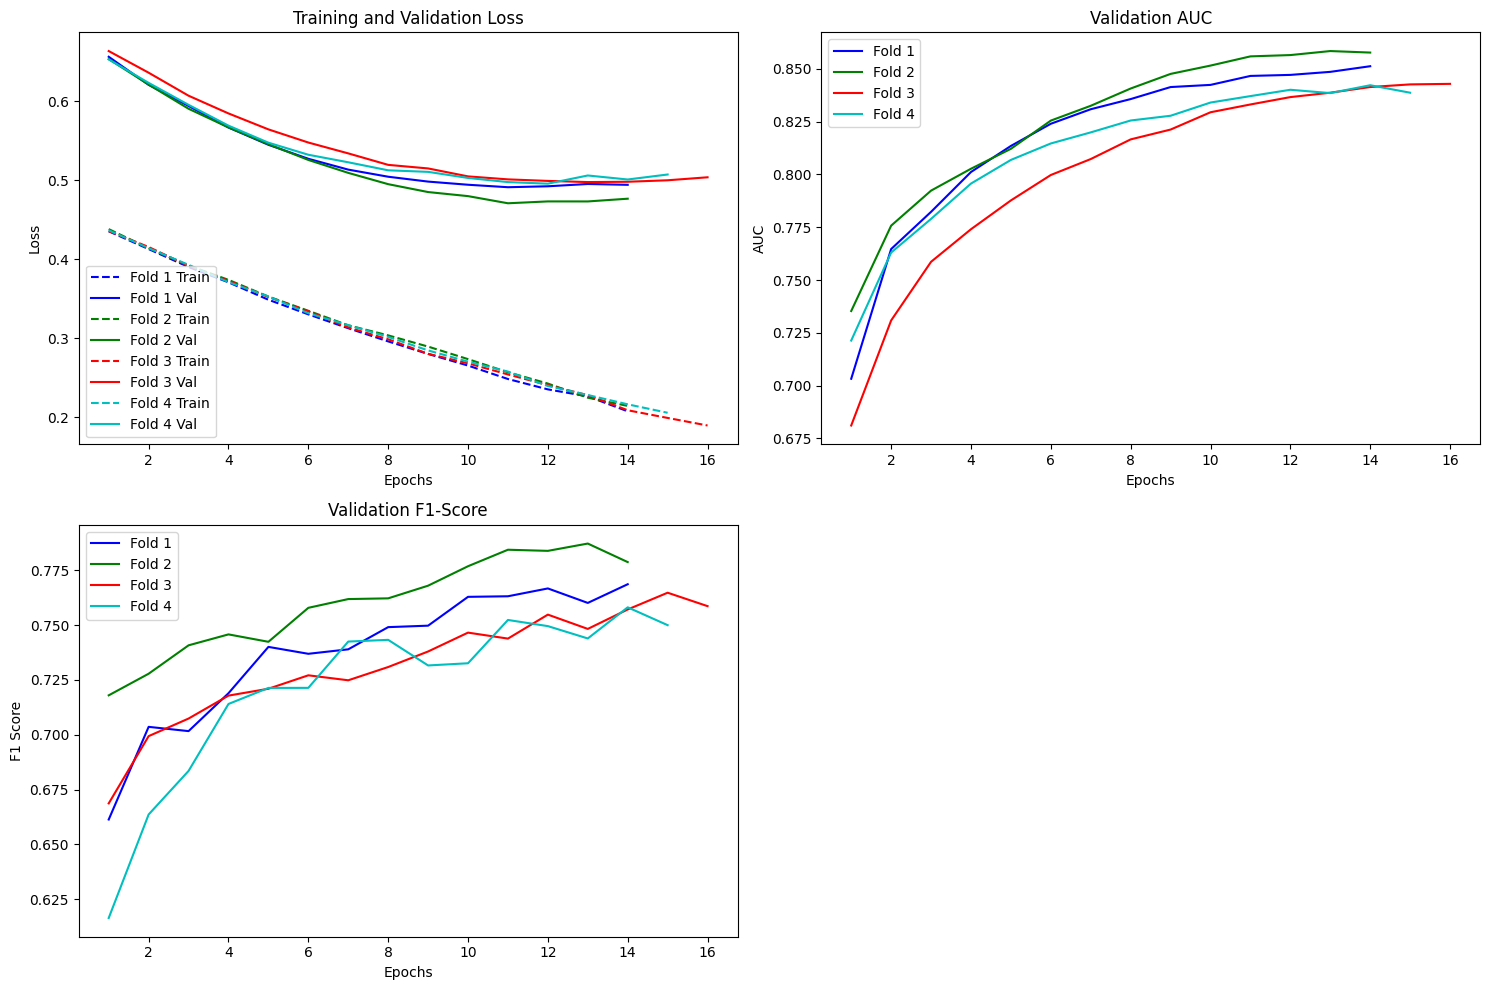

[codecarbon WARNING @ 02:30:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 02:30:38] [setup] RAM Tracking...
[codecarbon INFO @ 02:30:38] [setup] CPU Tracking...
[codecarbon WARNING @ 02:30:38] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 02:30:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 02:30:38] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 02:30:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 02:30:38] [setup] GPU Tracking...
[codecarbon INFO @ 02:30:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:30:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 5/5


[codecarbon INFO @ 02:31:22] Energy consumed for RAM : 0.118700 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:31:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:31:22] Energy consumed for All CPU : 0.132801 kWh
[codecarbon INFO @ 02:31:22] Energy consumed for all GPUs : 0.035560 kWh. Total GPU Power : 10.939403715569739 W
[codecarbon INFO @ 02:31:22] 0.287061 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:31:37] Energy consumed for RAM : 0.118858 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:31:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:31:37] Energy consumed for All CPU : 0.132978 kWh
[codecarbon INFO @ 02:31:37] Energy consumed for all GPUs : 0.035606 kWh. Total GPU Power : 10.928469092107855 W
[codecarbon INFO @ 02:31:37] 0.287441 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 5, Epoch 1/100
Train Loss: 0.4309 | Val Loss: 0.6660
Val AUC: 0.6537, F1: 0.6410


[codecarbon INFO @ 02:34:22] Energy consumed for RAM : 0.120599 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:34:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:34:22] Energy consumed for All CPU : 0.134925 kWh
[codecarbon INFO @ 02:34:22] Energy consumed for all GPUs : 0.036100 kWh. Total GPU Power : 10.830887470569294 W
[codecarbon INFO @ 02:34:22] 0.291624 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:34:37] Energy consumed for RAM : 0.120757 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:34:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:34:37] Energy consumed for All CPU : 0.135103 kWh
[codecarbon INFO @ 02:34:37] Energy consumed for all GPUs : 0.036146 kWh. Total GPU Power : 11.00099725368354 W
[codecarbon INFO @ 02:34:37] 0.292006 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:3

Fold 5, Epoch 2/100
Train Loss: 0.4073 | Val Loss: 0.6423
Val AUC: 0.6931, F1: 0.6611


[codecarbon INFO @ 02:37:37] Energy consumed for RAM : 0.122656 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:37:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:37:37] Energy consumed for All CPU : 0.137228 kWh
[codecarbon INFO @ 02:37:37] Energy consumed for all GPUs : 0.036689 kWh. Total GPU Power : 10.814174412092257 W
[codecarbon INFO @ 02:37:37] 0.296573 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:37:52] Energy consumed for RAM : 0.122815 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:37:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:37:52] Energy consumed for All CPU : 0.137405 kWh
[codecarbon INFO @ 02:37:52] Energy consumed for all GPUs : 0.036735 kWh. Total GPU Power : 10.980306468980029 W
[codecarbon INFO @ 02:37:52] 0.296954 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 5, Epoch 3/100
Train Loss: 0.3825 | Val Loss: 0.6248
Val AUC: 0.7104, F1: 0.6667


[codecarbon INFO @ 02:40:52] Energy consumed for RAM : 0.124714 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:40:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:40:52] Energy consumed for All CPU : 0.139530 kWh
[codecarbon INFO @ 02:40:52] Energy consumed for all GPUs : 0.037280 kWh. Total GPU Power : 10.94622762511625 W
[codecarbon INFO @ 02:40:52] 0.301524 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:41:07] Energy consumed for RAM : 0.124872 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:41:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:41:07] Energy consumed for All CPU : 0.139707 kWh
[codecarbon INFO @ 02:41:07] Energy consumed for all GPUs : 0.037326 kWh. Total GPU Power : 10.952139242395178 W
[codecarbon INFO @ 02:41:07] 0.301905 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:4

Fold 5, Epoch 4/100
Train Loss: 0.3615 | Val Loss: 0.6099
Val AUC: 0.7249, F1: 0.6655


[codecarbon INFO @ 02:43:53] Energy consumed for RAM : 0.126613 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:43:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:43:53] Energy consumed for All CPU : 0.141655 kWh
[codecarbon INFO @ 02:43:53] Energy consumed for all GPUs : 0.037831 kWh. Total GPU Power : 10.975476186019595 W
[codecarbon INFO @ 02:43:53] 0.306099 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:43:53] 0.002498 g.CO2eq/s mean an estimation of 78.77256649864367 kg.CO2eq/year
[codecarbon INFO @ 02:44:08] Energy consumed for RAM : 0.126771 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:44:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:44:08] Energy consumed for All CPU : 0.141832 kWh
[codecarbon INFO @ 02:44:08] Energy consumed for all GPUs : 0.037877 kWh. Total GPU Power : 11.070883781926337 W
[codecarbon INFO @ 02:44:08] 0.3

Fold 5, Epoch 5/100
Train Loss: 0.3397 | Val Loss: 0.5971
Val AUC: 0.7422, F1: 0.6874


[codecarbon INFO @ 02:47:08] Energy consumed for RAM : 0.128671 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:47:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:08] Energy consumed for All CPU : 0.143957 kWh
[codecarbon INFO @ 02:47:08] Energy consumed for all GPUs : 0.038432 kWh. Total GPU Power : 11.156823682614819 W
[codecarbon INFO @ 02:47:08] 0.311060 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:47:23] Energy consumed for RAM : 0.128829 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:47:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:23] Energy consumed for All CPU : 0.144134 kWh
[codecarbon INFO @ 02:47:23] Energy consumed for all GPUs : 0.038479 kWh. Total GPU Power : 11.258622301816898 W
[codecarbon INFO @ 02:47:23] 0.311443 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 5, Epoch 6/100
Train Loss: 0.3206 | Val Loss: 0.5866
Val AUC: 0.7549, F1: 0.6738


[codecarbon INFO @ 02:50:08] Energy consumed for RAM : 0.130570 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:50:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:50:08] Energy consumed for All CPU : 0.146082 kWh
[codecarbon INFO @ 02:50:08] Energy consumed for all GPUs : 0.038991 kWh. Total GPU Power : 11.084754348625681 W
[codecarbon INFO @ 02:50:08] 0.315643 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:50:23] Energy consumed for RAM : 0.130728 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:50:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:50:23] Energy consumed for All CPU : 0.146259 kWh
[codecarbon INFO @ 02:50:23] Energy consumed for all GPUs : 0.039037 kWh. Total GPU Power : 10.958958881820113 W
[codecarbon INFO @ 02:50:23] 0.316024 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 5, Epoch 7/100
Train Loss: 0.3012 | Val Loss: 0.5804
Val AUC: 0.7649, F1: 0.6765


[codecarbon INFO @ 02:53:23] Energy consumed for RAM : 0.132628 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:53:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:53:23] Energy consumed for All CPU : 0.148384 kWh
[codecarbon INFO @ 02:53:23] Energy consumed for all GPUs : 0.039586 kWh. Total GPU Power : 11.023516799134546 W
[codecarbon INFO @ 02:53:23] 0.320597 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:53:38] Energy consumed for RAM : 0.132786 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:53:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:53:38] Energy consumed for All CPU : 0.148561 kWh
[codecarbon INFO @ 02:53:38] Energy consumed for all GPUs : 0.039632 kWh. Total GPU Power : 11.00710569613684 W
[codecarbon INFO @ 02:53:38] 0.320979 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:5

Fold 5, Epoch 8/100
Train Loss: 0.2861 | Val Loss: 0.5741
Val AUC: 0.7738, F1: 0.6691


[codecarbon INFO @ 02:56:23] Energy consumed for RAM : 0.134527 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:56:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:56:23] Energy consumed for All CPU : 0.150509 kWh
[codecarbon INFO @ 02:56:23] Energy consumed for all GPUs : 0.040134 kWh. Total GPU Power : 10.84409397165231 W
[codecarbon INFO @ 02:56:23] 0.325169 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:56:38] Energy consumed for RAM : 0.134685 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:56:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:56:38] Energy consumed for All CPU : 0.150686 kWh
[codecarbon INFO @ 02:56:38] Energy consumed for all GPUs : 0.040180 kWh. Total GPU Power : 11.047198334107662 W
[codecarbon INFO @ 02:56:38] 0.325551 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:5

Fold 5, Epoch 9/100
Train Loss: 0.2715 | Val Loss: 0.5768
Val AUC: 0.7762, F1: 0.6821


[codecarbon INFO @ 02:59:38] Energy consumed for RAM : 0.136585 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:59:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:59:38] Energy consumed for All CPU : 0.152811 kWh
[codecarbon INFO @ 02:59:38] Energy consumed for all GPUs : 0.040732 kWh. Total GPU Power : 11.053934097571544 W
[codecarbon INFO @ 02:59:38] 0.330127 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:59:53] Energy consumed for RAM : 0.136743 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 02:59:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:59:53] Energy consumed for All CPU : 0.152988 kWh
[codecarbon INFO @ 02:59:53] Energy consumed for all GPUs : 0.040778 kWh. Total GPU Power : 11.232399840492473 W
[codecarbon INFO @ 02:59:53] 0.330509 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:

Fold 5, Epoch 10/100
Train Loss: 0.2554 | Val Loss: 0.5757
Val AUC: 0.7829, F1: 0.6882


[codecarbon INFO @ 03:02:53] Energy consumed for RAM : 0.138642 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 03:02:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:02:53] Energy consumed for All CPU : 0.155113 kWh
[codecarbon INFO @ 03:02:53] Energy consumed for all GPUs : 0.041337 kWh. Total GPU Power : 11.287075462767698 W
[codecarbon INFO @ 03:02:53] 0.335092 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 03:03:08] Energy consumed for RAM : 0.138800 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 03:03:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 03:03:08] Energy consumed for All CPU : 0.155289 kWh
[codecarbon INFO @ 03:03:08] Energy consumed for all GPUs : 0.041384 kWh. Total GPU Power : 11.174381328466438 W
[codecarbon INFO @ 03:03:08] 0.335474 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 03:

Fold 5, Epoch 11/100
Train Loss: 0.2371 | Val Loss: 0.5773
Val AUC: 0.7869, F1: 0.7016
Early stopping at epoch 11


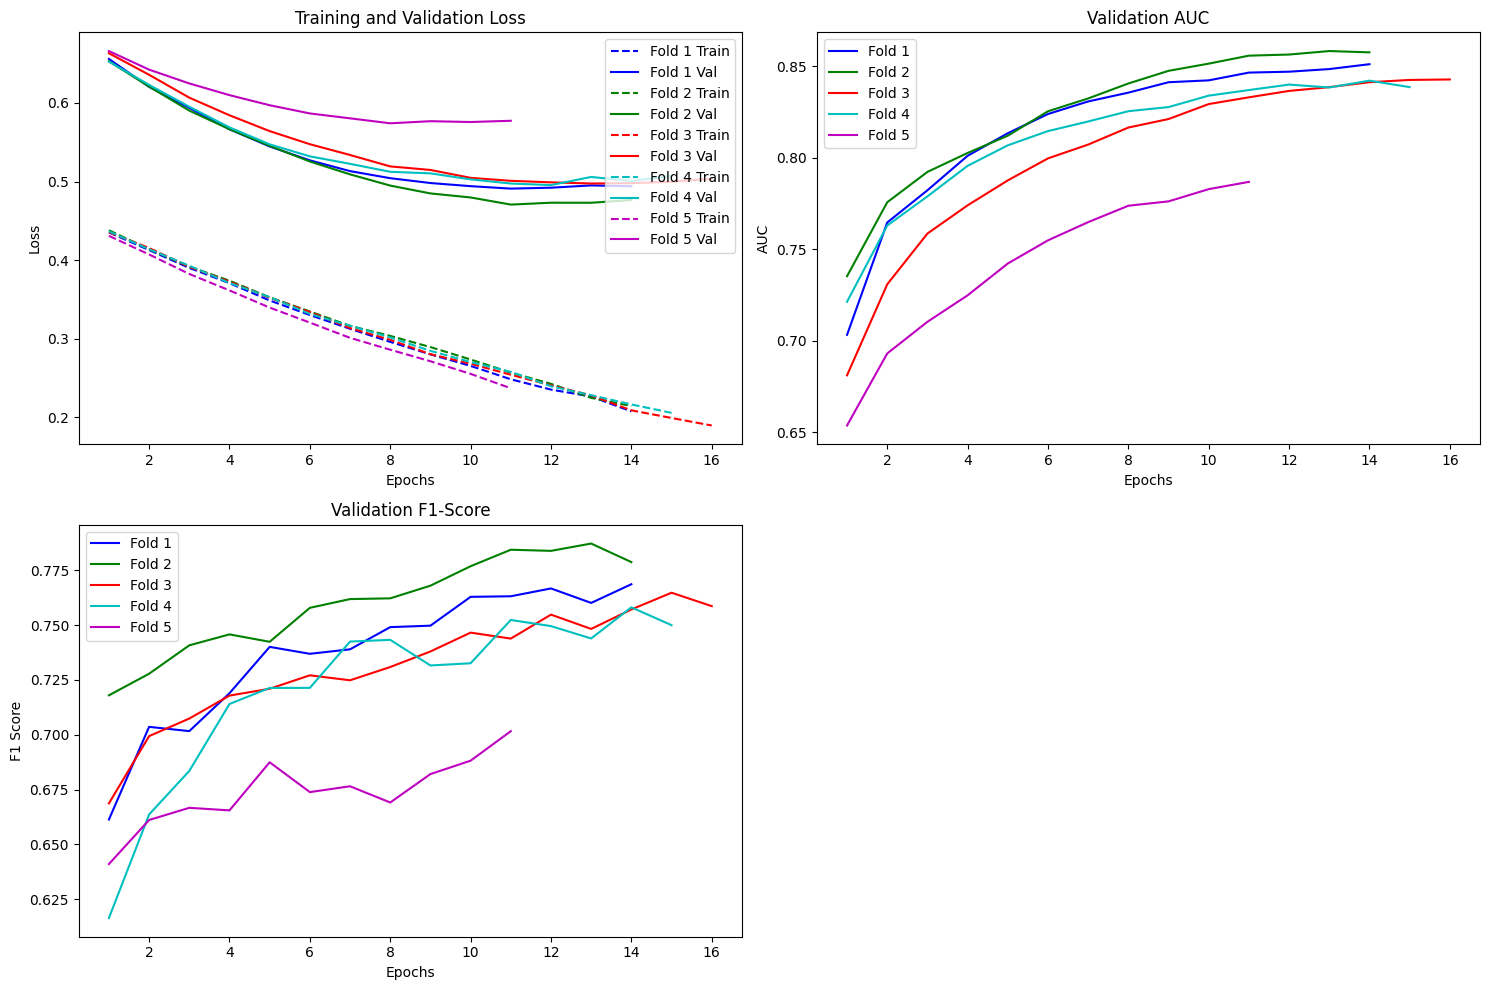

[codecarbon WARNING @ 03:05:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 03:05:48] [setup] RAM Tracking...
[codecarbon INFO @ 03:05:48] [setup] CPU Tracking...
[codecarbon WARNING @ 03:05:48] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 03:05:48] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 03:05:48] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 03:05:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 03:05:48] [setup] GPU Tracking...
[codecarbon INFO @ 03:05:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:05:48] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Resultados da Validação Cruzada:

--- Métricas de Validação ---
Val_AUC: 0.8310 ± 0.0292
Val_PR_AUC: 0.8362 ± 0.0314
Val_F1: 0.7429 ± 0.0391
Val_ACCURACY: 0.7521 ± 0.0335
Val_PRECISION: 0.7698 ± 0.0319
Val_RECALL: 0.7184 ± 0.0483

--- Métricas de Teste Interno ---
Test_AUC: 0.8827 ± 0.0150
Test_PR_AUC: 0.8977 ± 0.0101
Test_F1: 0.7894 ± 0.0145
Test_ACCURACY: 0.7989 ± 0.0122
Test_PRECISION: 0.8290 ± 0.0166
Test_RECALL: 0.7540 ± 0.0259
CPU times: total: 3d 13h 58min 36s
Wall time: 3h 42min 37s


In [12]:
%%time
# Executar
if __name__ == "__main__":
    fold_histories, all_metrics = cross_validation()

    # Exemplo Grad-CAM
    # model = create_model().eval()
    # sample_img, _ = dataset[0]
    # target_layer = model.layer4[-1] if MODEL_NAME == "resnet50" else model.features[-1]
    # cam_image = generate_grad_cam(model, sample_img.to(DEVICE), target_layer)
    #
    # plt.imshow(cam_image)
    # plt.title('Grad-CAM Visualization')
    # plt.axis('off')
    # plt.show()